## Objective
This notebook aims to develop a predictive model for apartment prices in Palestinian cities using the provided dataset. It covers data preparation, augmentation of underrepresented cities, and training an XGBoost regression model with cross-validation to ensure robust performance. The final model is designed to accurately estimate property prices based on features such as area, number of rooms and bathrooms, building age, and location, while providing a consistent and interpretable prediction framework.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from math import ceil
import arabic_reshaper
from bidi.algorithm import get_display

### Handling arabic text
Since Matplotlib has limited support for rendering Arabic text, a reshaper function will be used to ensure proper display.

In [2]:
def process_arabic_text(text):
    if isinstance(text, str):
        reshaped_text = arabic_reshaper.reshape(text)
        return get_display(reshaped_text)
    return text

In [3]:
df = pd.read_csv("Apts.csv", encoding = 'utf-8-sig')
df = df.drop(df.columns[0], axis=1)
df.head()

,السعر بالشيكل,المدينة,عدد الغرف,عدد الحمامات,مفروشة,مساحة البناء,الطابق,عمر البناء,العقار مرهون,طريقة الدفع,مصعد,موقف سيارات
0,397476,نابلس,3,2,0,138,2,2,False,0,True,True
1,400000,رام الله والبيرة,3,2,0,105,3,0,False,0,False,False
2,198738,جنين,3,2,0,165,1,1,False,2,False,False
3,1780608,بيت لحم,3,3,2,300,11,3,False,0,True,True
4,530000,رام الله والبيرة,3,3,0,185,2,3,False,0,True,True


## Data Augmentation
To improve model generalization across cities, properties from underrepresented cities are oversampled using bootstrap sampling to reach predefined target counts. Augmentation is applied **only on the training split**, ensuring no information leakage into validation or test sets. During duplication, controlled Gaussian noise is added to continuous features like area and price, while small perturbations are applied to discrete features such as rooms, bathrooms, and building age. These augmentations create realistic diversity in the dataset while preserving the key relationships.


In [4]:
before_counts = df["المدينة"].value_counts().sort_values(ascending=False)
print("\nCity counts BEFORE augmentation:")
print(before_counts.to_string())


City counts BEFORE augmentation:
المدينة
رام الله والبيرة    472
نابلس               173
بيت لحم             124
الخليل              101
جنين                 91
طولكرم               89
القدس                89
أخرى                 16


In [5]:
# parameters
price_noise_pct = 0.02        # 3% std dev relative noise for price
area_noise_pct  = 0.02        # 3% std dev relative noise for area
rooms_prob = 0.15             # chance to +/- 1 room for duplicated row
baths_prob = 0.12             # chance to +/- 1 bath for duplicated row
random_seed = 42

np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
# group cities with less than 15 rows as others
small_cities = before_counts[before_counts < 25].index.tolist()
df2 = df.copy()
df2["المدينة"] = df2["المدينة"].apply(lambda c: "أخرى" if c in small_cities else c)

In [7]:
grouped_counts = df2["المدينة"].value_counts().sort_values(ascending=False)
print("\nCity counts AFTER grouping small cities into 'أخرى':")
print(grouped_counts.to_string())
df2.to_csv("Apts.csv")


City counts AFTER grouping small cities into 'أخرى':
المدينة
رام الله والبيرة    472
نابلس               173
بيت لحم             124
الخليل              101
جنين                 91
طولكرم               89
القدس                89
أخرى                 16


In [27]:
def decide_target(n):
    if n >= 200:
        return n
    elif n >= 140:
        return 200
    elif n >= 120:
        return 140
    elif n >= 80:
        return 100
    elif n >= 40:
        return 100
    elif n >= 15:
        return 60
    else:
        return 40

def compute_city_targets(df_in):
    grouped_counts = df_in["المدينة"].value_counts()
    city_targets = {city: decide_target(cnt) for city, cnt in grouped_counts.items()}
    return city_targets

In [28]:
city_targets = {}
for city, cnt in grouped_counts.items():
    tgt = decide_target(cnt)
    city_targets[city] = {"count": int(cnt), "target": int(tgt)}

print("\nPer-city augmentation targets (city : current -> target):")
for city, d in city_targets.items():
    print(f" {city}: {d['count']} -> {d['target']}")


Per-city augmentation targets (city : current -> target):
 رام الله والبيرة: 472 -> 472
 نابلس: 173 -> 200
 بيت لحم: 124 -> 140
 الخليل: 101 -> 100
 جنين: 91 -> 100
 طولكرم: 89 -> 100
 القدس: 89 -> 100
 أخرى: 16 -> 60


In [29]:
def augment_city_data(df_in, city_targets, price_noise_pct=0.02, area_noise_pct=0.02,
                      rooms_prob=0.15, baths_prob=0.12, seed=42):
    np.random.seed(seed)
    random.seed(seed)
    rows_to_add = []

    for city, target in city_targets.items():
        source = df_in[df_in["المدينة"] == city]
        current = len(source)
        if target <= current:
            continue
        deficit = target - current
        sampled = source.sample(n=deficit, replace=True, random_state=seed)

        for _, r in sampled.iterrows():
            newr = r.copy()

            # jitter area
            try:
                area = float(newr["مساحة البناء"])
                area_jitter = np.random.normal(loc=area, scale=abs(area)*area_noise_pct)
                newr["مساحة البناء"] = int(max(10, round(area_jitter)))
            except Exception:
                pass

            # jitter rooms
            try:
                rooms = int(newr["عدد الغرف"])
                if np.random.rand() < rooms_prob:
                    rooms += np.random.choice([-1, 1])
                newr["عدد الغرف"] = int(max(1, rooms))
            except Exception:
                pass

            # jitter baths
            try:
                baths = int(newr["عدد الحمامات"])
                if np.random.rand() < baths_prob:
                    baths += np.random.choice([-1, 1])
                newr["عدد الحمامات"] = int(max(1, baths))
            except Exception:
                pass

            # jitter age mildly
            try:
                age = int(newr["عمر البناء"])
                age_j = age + np.random.choice([-1, 0, 1], p=[0.1, 0.8, 0.1])
                newr["عمر البناء"] = int(min(max(age_j, 0), 5))
            except Exception:
                pass

            # jitter price
            try:
                price = float(newr["السعر بالشيكل"])
                price_j = np.random.normal(loc=price, scale=abs(price)*price_noise_pct)
                newr["السعر بالشيكل"] = int(max(1000, round(price_j)))
            except Exception:
                pass

            rows_to_add.append(newr)

    return pd.concat([df_in, pd.DataFrame(rows_to_add)], ignore_index=True)

## Modeling
A predictive model for apartment prices is developed using XGBoost. Base parameters that perform well are specified, and hyperparameter tuning is performed using randomized search around these values. Multiple train/test splits are evaluated to identify the best-performing model, and post-prediction adjustments, such as accounting for parking, are applied. The model’s performance is visualized, and it can be used for individual price predictions.

### Base Parameters and Hyperparameter Grid
We use a set of base parameters for XGBoost that have already shown promising results in earlier experiments. These serve as a strong starting point for training. A hyperparameter grid is defined around these values, exploring ranges for the number of estimators, learning rate, maximum depth, and subsampling ratios to improve model performance through randomized search.

In [30]:
import random
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# Base params 
xgb_base_params = dict(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=5,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    max_delta_step=1,
    tree_method="hist",
    grow_policy="depthwise",
    n_jobs=-1,
    verbosity=0,
    random_state=42
)

param_distributions = {
    "n_estimators": [400, 500, 600],
    "learning_rate": [0.03, 0.05, 0.07],
    "max_depth": [4,5,6],
    "min_child_weight": [1, 2, 3],
    "gamma": [0, 0.05, 0.1],
    "reg_alpha": [0, 0.1],
    "reg_lambda": [1.0, 2.0],
    "subsample": [0.8, 0.85, 0.9],
    "colsample_bytree": [0.8, 0.85, 0.9],
    "max_delta_step": [0],
    "tree_method": ["hist"],
    "grow_policy": ["depthwise"]
}

## Data Loading and Preparation
The dataset is loaded and separated into features and target variables. Columns not used for modeling, such as the elevator, are dropped (more on this in the [elevator feature inspection notebook](https://github.com/AlaaArmoush/Aqari-Al-Dhaki/blob/main/Elevator%20Feature%20Analysis.ipynb)), while city information is one-hot encoded. City categories and feature columns (excluding parking) are saved to ensure consistency during predictions.

In [31]:
# Load dataset
df = pd.read_csv("Apts.csv", index_col=0)

# Target
y = df['السعر بالشيكل']

# Features — drop target and مصعد (elevator)
X = df.drop(columns=['السعر بالشيكل', 'مصعد'])

# One-hot encode city
X = pd.get_dummies(X, columns=['المدينة'], drop_first=True)

# Save city categories for prediction function
city_categories = [col.replace('المدينة_', '') for col in X.columns if col.startswith('المدينة_')]

# Save feature columns (exclude موقف سيارات, used post-prediction)
feature_cols = X.drop(columns=['موقف سيارات'], errors='ignore').columns.tolist()


In [32]:
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import numpy as np
import pandas as pd

SEED = 42
split_sizes = [0.15, 0.2, 0.25, 0.3]

results = []

## Train/Test Splitting, Data Augmentation, and Model Evaluation

For each train/test split:

1. **Split the dataset** into training and test sets, keeping the city column (`المدينة`) for augmentation.  
2. **Augment the training set** per city using `augment_city_data`, adding Gaussian noise to continuous features and small perturbations to discrete features.  
3. **Prepare features**: drop `السعر بالشيكل`, `مصعد`, and `موقف سيارات`; one-hot encode cities; align test columns to training.  
4. **Train XGBoost with RandomizedSearchCV**, tuning hyperparameters via 10-fold CV and printing the best parameters.  
5. **Evaluate on the test set**, apply parking adjustment if present, and compute Test R², CV R², MAE ratio, and RMSE ratio.  
6. **Store results** for comparison across splits to select the best model.


In [33]:
# Train/Test Splitting and Augmentation
for test_size in split_sizes:
    print(f"\n=== Evaluating split={1-test_size:.2f}/{test_size:.2f} ===")
    
    train_df, test_df = train_test_split(
        df, 
        test_size=test_size, 
        random_state=SEED, 
        shuffle=True
    )
    print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")
    
    y_train = train_df['السعر بالشيكل']
    y_test = test_df['السعر بالشيكل']
    
    city_targets_train = compute_city_targets(train_df)
    print("City target counts (train):", city_targets_train)
    
    # Augment training data
    train_augmented = augment_city_data(
        train_df, city_targets_train,
        price_noise_pct, area_noise_pct,
        rooms_prob, baths_prob, SEED
    )
    print(f"Augmented training size: {len(train_augmented)} (before: {len(train_df)})")
    
    # Separate features and target after augmentation
    X_train = train_augmented.drop(columns=['السعر بالشيكل', 'مصعد', 'موقف سيارات'])
    y_train = train_augmented['السعر بالشيكل']

    X_test = test_df.drop(columns=['السعر بالشيكل', 'مصعد', 'موقف سيارات'])
    # One-hot encode cities in train + test to keep same columns
    X_train = pd.get_dummies(X_train, columns=['المدينة'], drop_first=True)
    X_test = pd.get_dummies(X_test, columns=['المدينة'], drop_first=True)
    
    # Align test columns with train (in case some cities missing in test)
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    print("Starting RandomizedSearchCV...")
    xgb = XGBRegressor(n_jobs=-1, verbosity=0, random_state=SEED)
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    
    random_search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_distributions,
        n_iter=10,
        scoring='r2',
        cv=kf,
        verbose=1,
        random_state=SEED,
        n_jobs=-1
    )
    
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    print("Best hyperparameters found:", random_search.best_params_)
    
    # Evaluation on Test Set
        # Predict on test set
    y_test_pred = best_model.predict(X_test)
    
    # Apply parking adjustment if present
    if 'موقف سيارات' in df.columns:
        parking_test = test_df['موقف سيارات'].astype(int)
        y_test_pred = np.where(parking_test == 1, y_test_pred * 1.011, y_test_pred)
    
    # Metrics
    test_r2 = r2_score(y_test, y_test_pred)
    mean_y_test = y_test.mean()
    test_mae = mean_absolute_error(y_test, y_test_pred) / mean_y_test
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred)) / mean_y_test
    cv_r2 = random_search.best_score_
    
    print(f"Split summary: Test R²={test_r2:.4f}, CV R²={cv_r2:.4f}, "
          f"MAE ratio={test_mae:.4f}, RMSE ratio={test_rmse:.4f}")
    
    results.append({
        "test_size": test_size,
        "cv_r2": cv_r2,
        "test_r2": test_r2,
        "test_mae": test_mae,
        "test_mse": mean_squared_error(y_test, y_test_pred),
        "test_rmse": test_rmse,
        "model": best_model,
        "y_test": y_test,
        "y_test_pred": y_test_pred
    })


=== Evaluating split=0.85/0.15 ===
Train size: 981, Test size: 174
City target counts (train): {'رام الله والبيرة': 401, 'نابلس': 200, 'بيت لحم': 100, 'جنين': 100, 'الخليل': 100, 'طولكرم': 100, 'القدس': 100, 'أخرى': 40}
Augmented training size: 1150 (before: 981)
Starting RandomizedSearchCV...
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best hyperparameters found: {'tree_method': 'hist', 'subsample': 0.85, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 6, 'max_delta_step': 0, 'learning_rate': 0.07, 'grow_policy': 'depthwise', 'gamma': 0.1, 'colsample_bytree': 0.85}
Split summary: Test R²=0.7514, CV R²=0.7451, MAE ratio=0.1577, RMSE ratio=0.2417

=== Evaluating split=0.80/0.20 ===
Train size: 924, Test size: 231
City target counts (train): {'رام الله والبيرة': 377, 'نابلس': 140, 'بيت لحم': 100, 'جنين': 100, 'الخليل': 100, 'القدس': 100, 'طولكرم': 100, 'أخرى': 40}
Augmented training size: 1059 (before: 924)
Starting Random

## Selecting the Best Split

In [15]:
# Select best split
best_result = max(results, key=lambda r: r['cv_r2'])
model = best_result['model']
y_test_ser = best_result['y_test']
y_test_pred = best_result['y_test_pred']

print(f"\nSelected best split: {1-best_result['test_size']:.2f}/"
      f"{best_result['test_size']:.2f} with Test R²={best_result['test_r2']:.4f} "
      f"and CV R²={best_result['cv_r2']:.4f}")



Selected best split: 0.85/0.15 with Test R²=0.7797 and CV R²=0.7477


### Prediction Diagnostics

We visualize how well the model predicts prices by plotting actual versus predicted values. The plot includes an ideal y=x line to see how close predictions are to the true prices, and a regression fit line to spot any systematic bias. Residuals and errors can also be examined to understand where the model over- or under-predicts.



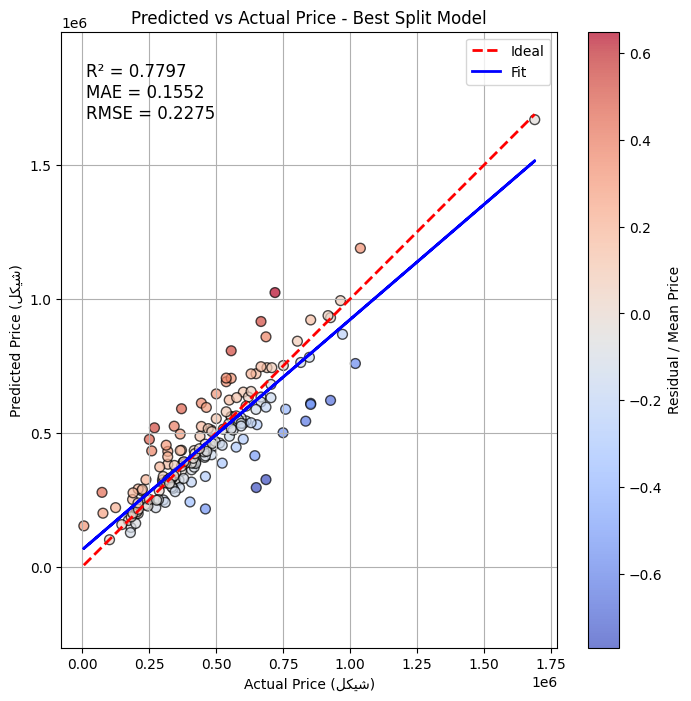

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Linear regression fit for visualization
lr = LinearRegression()
lr.fit(y_test_ser.values.reshape(-1, 1), y_test_pred)
y_fit = lr.predict(y_test_ser.values.reshape(-1, 1))

# Residuals
residuals = y_test_pred - y_test_ser
r2 = r2_score(y_test_ser, y_test_pred)

# MAE and RMSE as ratios
mean_y_test = y_test_ser.mean()
mae_ratio = mean_absolute_error(y_test_ser, y_test_pred) / mean_y_test
rmse_ratio = np.sqrt(mean_squared_error(y_test_ser, y_test_pred)) / mean_y_test

plt.figure(figsize=(8, 8))
plt.scatter(y_test_ser, y_test_pred, c=residuals / mean_y_test, cmap='coolwarm', s=50, edgecolor='k', alpha=0.7)

# Ideal y=x line
xmin, xmax = min(y_test_ser.min(), y_test_pred.min()), max(y_test_ser.max(), y_test_pred.max())
plt.plot([xmin, xmax], [xmin, xmax], 'r--', lw=2, label='Ideal')

# Regression fit line
plt.plot(y_test_ser, y_fit, 'b-', lw=2, label='Fit')

plt.xlabel(f'Actual Price {process_arabic_text("(شيكل)")}')
plt.ylabel(f'Predicted Price {process_arabic_text("(شيكل)")}')
plt.title('Predicted vs Actual Price - Best Split Model')
plt.legend()
plt.grid(True)
plt.axis('equal')

# Annotate metrics properly
metrics_text = f'R² = {r2:.4f}\nMAE = {mae_ratio:.4f}\nRMSE = {rmse_ratio:.4f}'
plt.text(0.05, 0.95, metrics_text,
         transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top')

# Colorbar for residuals
cbar = plt.colorbar()
cbar.set_label('Residual / Mean Price')

plt.show()

### Predection Function
A function predicts the price of a single apartment input. It aligns features with the training set, one-hot encodes city categories, and applies a  parking post predection adjustment if needed (more on this in the [parking feature analysis notebook](https://github.com/AlaaArmoush/Aqari-Al-Dhaki/blob/main/Parking%20Feature%20Analysis.ipynb)), ensuring reliable predictions for new data points using the trained model.

In [17]:
def predict_price(model, input_row, city_categories, feature_columns, apply_parking_adjust=True):
    import pandas as pd
    import numpy as np

    df_input = pd.DataFrame([input_row])

    # capture parking flag (safe fallback to False)
    parking = df_input.get('موقف سيارات', pd.Series([False])).iloc[0]

    # one-hot encode cities the same way training used (columns like 'المدينة_<name>')
    for city in city_categories:
        col_name = f'المدينة_{city}'
        df_input[col_name] = (df_input.get('المدينة') == city).astype(int)

    # drop original city column (the dummies are created)
    if 'المدينة' in df_input.columns:
        df_input = df_input.drop(columns=['المدينة'])

    # drop parking from features if present (we don't train with it)
    if 'موقف سيارات' in df_input.columns:
        df_input = df_input.drop(columns=['موقف سيارات'])

    # align columns to training features; fill missing with 0
    df_input = df_input.reindex(columns=feature_columns, fill_value=0)

    # predict price (model outputs original price)
    y_pred = model.predict(df_input)[0]

    # apply parking adjustment only after prediction
    if apply_parking_adjust and parking:
        y_pred = y_pred * 1.011

    return float(y_pred)


### Example Usage

In [34]:
city_categories = [col.replace('المدينة_', '') for col in X.columns if col.startswith('المدينة_')]

example_input = {
    'عدد الغرف': 1,
    'عدد الحمامات': 1,
    'مفروشة': 1,
    'مساحة البناء': 150,
    'الطابق': 3,
    'عمر البناء': 4,
    'العقار مرهون': False,
    'طريقة الدفع': 2,
    'موقف سيارات': True,   # only used for post-prediction adjustment
    'المدينة': 'نابلس'
}

# Feature columns actually used for training (exclude موقف سيارات)
feature_cols_for_prediction = [c for c in feature_cols if c != 'موقف سيارات']

predicted_price = predict_price(
    model=model,  # best model from hyperparameter tuning / split selection
    input_row=example_input,
    feature_columns=feature_cols_for_prediction,
    city_categories=city_categories,
    apply_parking_adjust=True
)

print(f"Predicted Price (شيكل): {predicted_price:.2f}")


Predicted Price (شيكل): 366997.53


### Save Model For Deployment

In [19]:
import os
import joblib

# create folder if it doesn't exist
os.makedirs("model", exist_ok=True)

# save model and metadata
joblib.dump(model, "model/final_model.pkl")
joblib.dump(feature_cols_for_prediction, "model/feature_columns.pkl")
joblib.dump(city_categories, "model/city_categories.pkl")

['model/city_categories.pkl']